In [ ]:
!pip install transformers

In [ ]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Text Mining Group Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1MRcmuqFK4K9-wbwnSfbOWkpqA7tjI6vv/Text Mining Group Project


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [ ]:
# Dataset class
class SocialMediaDS(Dataset):
    def __init__(self, data_path, sheet_name, model_ckpt, max_token_length=50):
        super().__init__()
        self.max_token_length = max_token_length
        self.emotion_labels = ['ANGER', 'DISGUST', 'FEAR', 'JOY', 'NEUTRAL', 'SADNESS', 'SURPRISE']
        self.data = pd.read_excel(data_path, sheet_name=sheet_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        self.tokenizer.add_special_tokens({"additional_special_tokens": ["[ENTITY]"]}) #Custom learned [ENTITY] token which replaces the entity of interest

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx, :]
        entity = row['entity'].strip()
        comment = row['text'].replace(entity, "[ENTITY]")
        comment = comment.split()

        # Long comments
        if len(comment) > self.max_token_length:
            # Get index of the entity in the comment
            for i, word in enumerate(comment):
                if "[ENTITY]" in word:
                    entity_ind = i
                    break
            start = max(entity_ind - int(self.max_token_length/2), 0)
            end = start + self.max_token_length
            comment = comment[start:end]

        comment = ' '.join(comment).replace("\\", "")
        emotion = self.emotion_labels.index(row['emotion'])
        return f"{comment} [SEP] [ENTITY]", emotion

    def choose(self):
        return self[randint(0, len(self)-1)]

    def get_tokenizer_size(self):
        return len(self.tokenizer)

    def decode(self, input_id):
        return self.tokenizer.decode(input_id)

    def collate_fn(self, data):
        comments, emotions = zip(*data)
        comments = self.tokenizer(
            comments,
            padding=True,
            truncation=True,
            max_length=self.max_token_length + 4,  # Room for [CLS], [SEP], [ENTITY]
            return_tensors='pt'
        )
        comments = {k: v.to(device) for k, v in comments.items()}
        emotions = torch.tensor(emotions).long().to(device)
        return comments, emotions

In [ ]:
# Model class
class EmotionClassifier(nn.Module):
    def __init__(self, model_ckpt, tokenizer, emotion_nlabels=7):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_ckpt)
        self.encoder.resize_token_embeddings(len(tokenizer))  # Dynamic vocab size
        encoder_config = self.encoder.config
        self.emotion_classifier = nn.Sequential(
            nn.BatchNorm1d(encoder_config.hidden_size),
            nn.Dropout(0.2),
            nn.Linear(encoder_config.hidden_size, emotion_nlabels)
        )
        self.emotion_classifier.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def get_summary(self):
        print(self)

    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.encoder(**x)
        x = x.last_hidden_state[:, 0]  # [CLS] embedding
        emotion_outputs = self.emotion_classifier(x)
        return emotion_outputs  # Logits

In [ ]:
# Metric and loss functions
def compute_metrics(targets, preds):
    targets = targets.cpu().detach()
    preds = preds.cpu().detach()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    return {'acc': acc, 'f1': f1, 'preds': preds, 'targets': targets}

In [ ]:
def focal_loss(gamma=2): #1
    def compute_loss(preds, targets):
        ce_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1-pt)**gamma * ce_loss).mean()
    return compute_loss

In [ ]:
# Training and validation functions
def train(data, model, optimizer, emo_loss_fn):
    model.train()
    comments, emotions = data
    emo_outputs = model(comments)
    emo_loss = emo_loss_fn(emo_outputs, emotions)
    loss = emo_loss
    model.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping here
    optimizer.step()

    emo_preds = emo_outputs.argmax(-1)
    emo_metrics = compute_metrics(emotions, emo_preds)
    return loss, emo_metrics

In [ ]:
@torch.no_grad()
def validate(data, model, emo_loss_fn):
    model.eval()
    comments, emotions = data
    emo_outputs = model(comments)
    emo_loss = emo_loss_fn(emo_outputs, emotions)
    loss = emo_loss
    emo_preds = emo_outputs.argmax(-1)
    emo_metrics = compute_metrics(emotions, emo_preds)
    return loss, emo_metrics

In [ ]:
# Training setup and loop
model_ckpt = "bert-base-uncased"
batch_size = 16
n_epoch = 10 #5

data_path = "./en_dataset.xlsx"
train_data_path = "./train.xlsx"
val_data_path = "./val.xlsx"
sheet_name = "Sheet1"

df = pd.read_excel(data_path)
df = df.applymap(lambda x: x.strip())
df = df.drop_duplicates()

<ipython-input-11-f590f49260e6>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip())


In [ ]:
df = df.drop_duplicates()
neutral_df = df[df['emotion'] == 'NEUTRAL'].sample(220) # under sample neutral
df = df[df['emotion'] != 'NEUTRAL']
df = pd.concat([df, neutral_df], ignore_index = True)
print(len(df))

1414


In [ ]:
df.emotion.value_counts()

,count
emotion,
NEUTRAL,220
JOY,216
SURPRISE,212
ANGER,203
SADNESS,200
FEAR,196
DISGUST,167


In [ ]:
train_df, val_df = train_test_split(df, stratify=df.loc[:, 'emotion'], test_size=0.1, random_state=123)
train_df.to_excel(train_data_path, index=False)
val_df.to_excel(val_data_path, index=False)
print(f'Size of training data: {len(train_df)}')
print(f'Size of validation data: {len(val_df)}')

Size of training data: 1272
Size of validation data: 142


In [ ]:
# DataLoaders
train_ds = SocialMediaDS(train_data_path, sheet_name, model_ckpt)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)
val_ds = SocialMediaDS(val_data_path, sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.add_special_tokens({"additional_special_tokens": ["[ENTITY]"]})
model = EmotionClassifier(model_ckpt, tokenizer, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Optimizer, scheduler, and loss
#loss_fn = focal_loss()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
# Training loop with memory tracking
mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}
cur_best_f1 = 0

for epoch in tqdm(range(n_epoch), desc='Training', unit='epoch'):
    # Training phase
    train_losses, train_accs, train_f1s = [], [], []
    train_loop = tqdm(train_dl, desc=f'Epoch {epoch+1}/{n_epoch} - Training', leave=False)
    for i, data in enumerate(train_loop):
        train_loss, train_metrics = train(data, model, optimizer, loss_fn)
        train_losses.append(train_loss.item())  # .item() for scalar
        train_accs.append(train_metrics['acc'])
        train_f1s.append(train_metrics['f1'])
        train_loop.set_postfix({
            'loss': f"{train_loss.item():.3f}",
            'acc': f"{train_metrics['acc']:.3f}",
            'f1': f"{train_metrics['f1']:.3f}"
        })

    # Store average training metrics
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_acc'].append(np.mean(train_accs))
    mem['train_f1'].append(np.mean(train_f1s))

    # Validation phase
    val_losses, val_accs, val_f1s = [], [], []
    val_loop = tqdm(val_dl, desc=f'Epoch {epoch+1}/{n_epoch} - Validation', leave=False)
    for i, data in enumerate(val_loop):
        val_loss, val_metrics = validate(data, model, loss_fn)
        val_losses.append(val_loss.item())
        val_accs.append(val_metrics['acc'])
        val_f1s.append(val_metrics['f1'])
        val_loop.set_postfix({
            'loss': f"{val_loss.item():.3f}",
            'acc': f"{val_metrics['acc']:.3f}",
            'f1': f"{val_metrics['f1']:.3f}"
        })

    # Store average validation metrics
    mem['val_loss'].append(np.mean(val_losses))
    mem['val_acc'].append(np.mean(val_accs))
    mem['val_f1'].append(np.mean(val_f1s))

    # Logging
    log = (f"Epoch {epoch+1}/{n_epoch}\n"
           f"Train Loss: {mem['train_loss'][-1]:.3f}\tAcc: {mem['train_acc'][-1]:.3f}\tF1: {mem['train_f1'][-1]:.3f}\n"
           f"Val Loss:   {mem['val_loss'][-1]:.3f}\tAcc:   {mem['val_acc'][-1]:.3f}\tF1:   {mem['val_f1'][-1]:.3f}\n")
    tqdm.write(log)

    # Scheduler step
    scheduler.step()

    # Save best model based on val_f1
    if mem['val_f1'][-1] > cur_best_f1:
        torch.save(model.state_dict(), "./saved_models/model_weights_bert.pth")
        cur_best_f1 = mem['val_f1'][-1]
        tqdm.write(f"New best F1: {cur_best_f1:.3f} - Model saved!")

# Final save (optional)
#torch.save(model.state_dict(), "./saved_models/model_weights_bert_final.pth")
print("Training completed!")

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 2.112	Acc: 0.336	F1: 0.344
Val Loss:   1.633	Acc:   0.422	F1:   0.438

New best F1: 0.438 - Model saved!


Epoch 2/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 1.300	Acc: 0.576	F1: 0.587
Val Loss:   1.427	Acc:   0.617	F1:   0.636

New best F1: 0.636 - Model saved!


Epoch 3/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.708	Acc: 0.771	F1: 0.787
Val Loss:   1.245	Acc:   0.648	F1:   0.648

New best F1: 0.648 - Model saved!


Epoch 4/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.553	Acc: 0.811	F1: 0.822
Val Loss:   1.281	Acc:   0.647	F1:   0.647



Epoch 5/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.442	Acc: 0.850	F1: 0.860
Val Loss:   1.252	Acc:   0.634	F1:   0.643



Epoch 6/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.448	Acc: 0.843	F1: 0.855
Val Loss:   1.257	Acc:   0.648	F1:   0.655

New best F1: 0.655 - Model saved!


Epoch 7/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.453	Acc: 0.847	F1: 0.855
Val Loss:   1.272	Acc:   0.612	F1:   0.621



Epoch 8/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.454	Acc: 0.849	F1: 0.865
Val Loss:   1.248	Acc:   0.648	F1:   0.657

New best F1: 0.657 - Model saved!


Epoch 9/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.423	Acc: 0.852	F1: 0.863
Val Loss:   1.265	Acc:   0.640	F1:   0.641



Epoch 10/10 - Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.456	Acc: 0.843	F1: 0.855
Val Loss:   1.265	Acc:   0.641	F1:   0.648

Training completed!


In [ ]:
emo_preds, emo_targets = [], []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dl), total=len(val_dl)):
        comments, emotions = data
        emo_outputs = model(comments)

        emo_preds.extend(emo_outputs.argmax(-1).cpu().numpy())
        emo_targets.extend(emotions.cpu().numpy())

    print("Emotion")
    print(classification_report(emo_targets, emo_preds))

  0%|          | 0/9 [00:00<?, ?it/s]

Emotion
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        20
           1       0.69      0.53      0.60        17
           2       0.58      0.70      0.64        20
           3       0.64      0.82      0.72        22
           4       0.54      0.68      0.60        22
           5       0.64      0.45      0.53        20
           6       0.78      0.67      0.72        21

    accuracy                           0.64       142
   macro avg       0.65      0.64      0.64       142
weighted avg       0.65      0.64      0.64       142



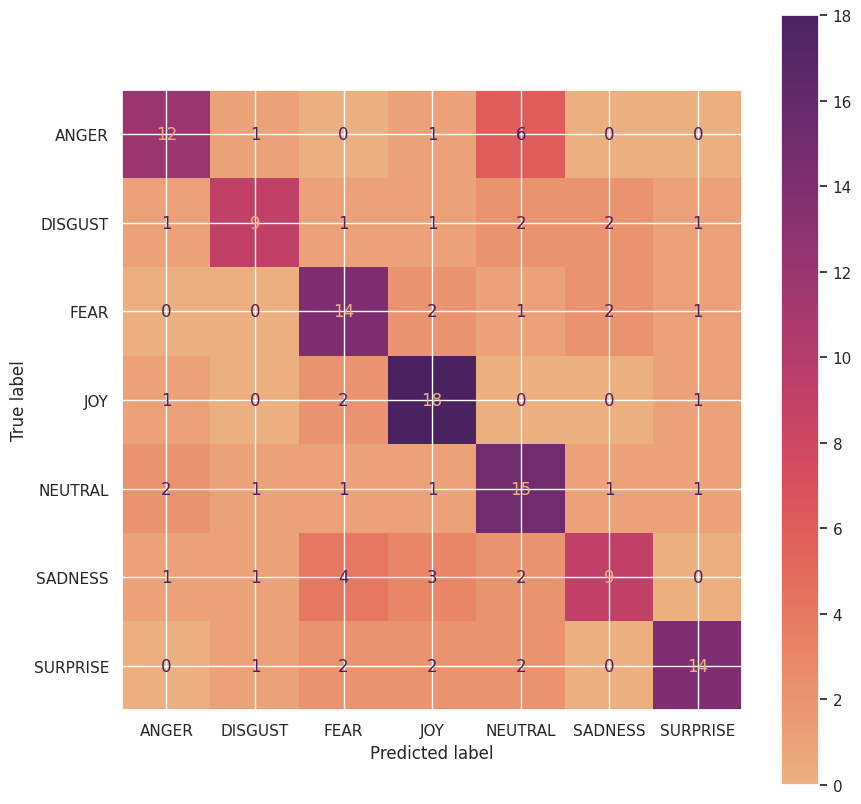

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
ConfusionMatrixDisplay.from_predictions(emo_targets, emo_preds,
                                        cmap='flare',
                                        display_labels=[
            'ANGER',
            'DISGUST',
            'FEAR',
            'JOY',
            'NEUTRAL',
            'SADNESS',
            'SURPRISE'
        ])
plt.show()

In [ ]:
@torch.no_grad()
def init_prediction(model):
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    emotion_labels = [
        'ANGER',
        'DISGUST',
        'FEAR',
        'JOY',
        'NEUTRAL',
        'SADNESS',
        'SURPRISE'
    ]

    def predict(text, entity):
        text = text + ' [SEP] ' + entity
        text = tokenizer(text, return_tensors='pt')
        text = {k:v.to(device) for k, v in text.items()}
        emo_output = model(text)
        emo_pred = emo_output.argmax(-1).cpu().detach()
        emo_label = emotion_labels[emo_pred]

        return emo_label

    return predict

In [ ]:
predictor = init_prediction(model)

In [ ]:
text = "pls lah [ENTITY] is acting in our best interest lorh! meanwhile WP still saying things like they against repeal cos of religion… lame lah!"
entity = "[ENTITY]"
predictor(text, entity)

'DISGUST'

In [ ]:
text = "pls lah PAP is acting in our best interest lorh! meanwhile [ENTITY] still saying things like they against repeal cos of religion… lame lah!"
entity = "[ENTITY]"
predictor(text, entity)

'DISGUST'

In [ ]:
text = "[ENTITY] made a very good speech in parliment this round."
entity = "[ENTITY]"
predictor(text, entity)

'JOY'